In [1]:
import NN_training
import MC_Sim
import Load_data
import Generate_plot as GP
import Trading

import numpy as np
import torch
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from scipy.stats import skew

In [2]:
#Generate simulation

#Get real stock price
Time_step = Load_data.Load_time_and_date(FlieLocation="Data/NVDA/past_data/price.csv")
NVDA_History = Load_data.Load_mutiple_data(FlieLocation="Data/NVDA/past_data/price.csv",ExtractLabels=["Open","Close"])
NVDA_Open = np.array(NVDA_History[0][0][0])
NVDA_Close = np.array(NVDA_History[0][1][0])

number_of_walk = 5 #  include a 5.5 sigma event = 1 in 26330254

Sample_start_date=datetime.date(2020,8,4)
Sample_end_date=datetime.date(2024,6,10)
Prediction_Ending_date = datetime.date(2024,7,5)

Plot_Starting_date = datetime.date(2017,8,4)
Plot_history_ending_date = Sample_end_date


New_Time_step, Open_prediction_ave, Open_predictions_sims = MC_Sim.Get_prediction(NVDA_Open,Time_step,number_of_walk,Sample_start_date,Sample_end_date,Prediction_Ending_date,"linear")

New_Time_step, Close_prediction_ave, Close_predictions_sims = MC_Sim.Get_prediction(NVDA_Close,Time_step,number_of_walk,Sample_start_date,Sample_end_date,Prediction_Ending_date,"linear")


Mean imputation done.
Nah value smoothed
Mean imputation done.
Nah value smoothed


In [3]:
#Get real stock price
Time_step_True = Load_data.Load_time_and_date(FlieLocation="Data/NVDA/new_data/price.csv")
NVDA_True = Load_data.Load_mutiple_data(FlieLocation="Data/NVDA/new_data/price.csv",ExtractLabels=["Open","Close"])
NVDA_True_Open = np.array(NVDA_True[0][0][0])
NVDA_True_Close = np.array(NVDA_True[0][1][0])

Mean imputation done.
Nah value smoothed
Mean imputation done.
Nah value smoothed


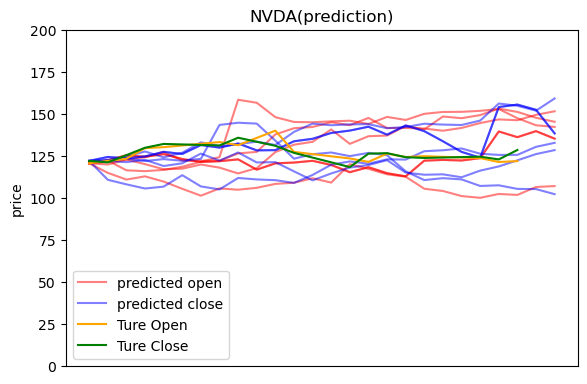

In [4]:
GP.Generated_plots_for_sims(Open_predictions_sims,New_Time_step,"predicted open","NVDA(prediction)","red")
GP.Generated_plots_for_sims(Close_predictions_sims,New_Time_step,"predicted close","NVDA(prediction)","blue")
GP.plot_true_stock_price([NVDA_True_Open,Time_step_True],Sample_end_date,"Ture Open","orange")
GP.plot_true_stock_price([NVDA_True_Close,Time_step_True],Sample_end_date,"Ture Close","Green")
plt.legend()
plt.ylim(0,200)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9)
plt.show()

In [5]:
# load model
my_model = NN_training.Model_structure(3, 1)
my_model.load_state_dict(torch.load('trained_weights/Moving_average_Gaussian_Close/NVDA/30_days.pth'))

<All keys matched successfully>

In [6]:
#prepare sim data
scorces = []
for i in range(len(Open_predictions_sims)):
    Open_sim = torch.tensor(Open_predictions_sims[i]).view(-1, 1).float()
    Close_sim = torch.tensor(Close_predictions_sims[i]).view(-1, 1).float()
    
    open_yestaday = Open_sim[:-1]
    close_yestaday = Close_sim[:-1]
    open_today = Open_sim[1:]
    
    Test_data = torch.cat((open_yestaday[:-1], close_yestaday[:-1], open_today[:-1]), dim=1)
    scorce = NN_training.Generate_scorce(my_model,Test_data).view(-1).detach().numpy()
    scorces.append([scorce])
    #plt.plot(New_Time_step[1:-1],scorce,alpha=0.005,color="blue")
#plt.ylabel("scorces")
#ax = plt.gca()
#ax.xaxis.set_major_locator(mdates.MonthLocator())
#plt.show()



In [7]:
#trading on sim
# if the scorce > 0.7, I buy;
#else if scorce < 0.5, I short;
#else, in between, I hold
Portfolios = []
alphas = []
for ii in range(len(scorces)):
    Portfolio = []
    Scorce = np.array(scorces[ii])
    Scorce = Scorce[0]
    Sim_Closes = np.array(Close_predictions_sims[ii][1:-1])
    Sim_Opens = np.array(Open_predictions_sims[ii][1:-1])
    alpha = []
    for jj in range(len(Scorce)):
        if Scorce[jj] > 0.7:
            action = 1
        elif Scorce[jj] < 0.5:
            action = -1
        else:
            action = 0
        gain = (Sim_Closes[jj] - Sim_Opens[jj])*action
        alpha.append(gain)
    Portfolio = np.cumsum(alpha)
    Portfolios.append(np.array(Portfolio))
    alphas.append(np.array(alpha))
    
means_alpha = np.mean(alphas, axis=0) #Checked axis correct
aplha_distibution = []
for j in range(len(alphas)):
    aplha_distibution.append(alphas[j][-1])
aplha_distibution = np.array(aplha_distibution)

means_Portfolio = np.mean(Portfolios, axis=0)
Portfolio_distibution = []
for j in range(len(Portfolios)):
    Portfolio_distibution.append(Portfolios[j][-1])
Portfolio_distibution = np.array(Portfolio_distibution)


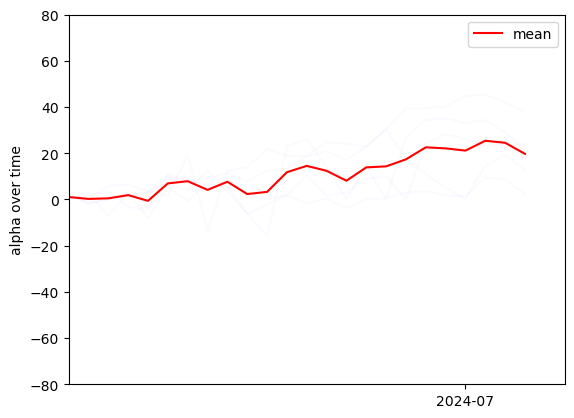

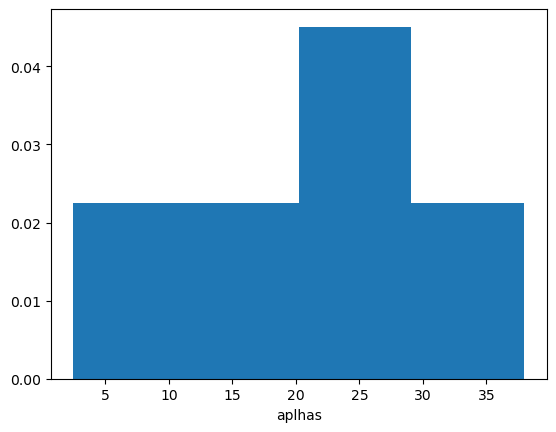

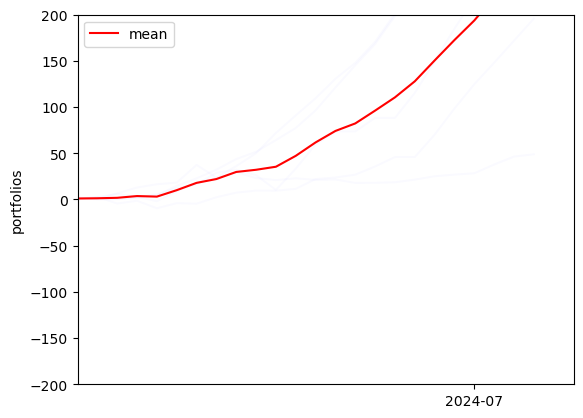

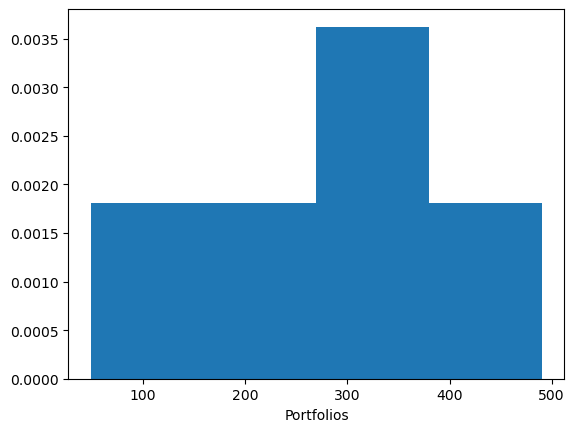

In [8]:
for a in alphas:
    plt.plot(New_Time_step[1:-1],a,alpha=0.021,color="blue")
plt.plot(New_Time_step[1:-1],means_alpha,label="mean", color="red")
plt.ylim(-80,80)
plt.ylabel("alpha over time")
plt.xlim(min(New_Time_step[1:-1]), max(New_Time_step[1:-1]) + datetime.timedelta(days=2))
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
#aplha_distibution, _ = GP.Generate_error_plot(alphas, New_Time_step[1:-1], "Green",1.5)
plt.legend()
plt.show()

plt.hist(aplha_distibution,bins="auto",density="True")
plt.xlabel("aplhas")
plt.show()

for p in Portfolios:
    plt.plot(New_Time_step[1:-1], p, alpha = 0.02, color="blue")
plt.plot(New_Time_step[1:-1],means_Portfolio,label="mean", color="red")
plt.ylim(-200,200)
plt.ylabel("portfolios")
plt.xlim(min(New_Time_step[1:-1]), max(New_Time_step[1:-1]) + datetime.timedelta(days=2))
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
#aplha_distibution, _ = GP.Generate_error_plot(alphas, New_Time_step[1:-1], "Green",1.5)
plt.legend()
plt.show()

plt.hist(Portfolio_distibution,bins="auto",density="True")
plt.xlabel("Portfolios")
plt.show()

In [9]:
#Sim result

Final_portfolio_mean = np.mean(Portfolio_distibution)
Final_portfolio_sd = np.std(Portfolio_distibution)
Final_portfolio_skewness = skew(Portfolio_distibution)
print("simulation result:")
print("The mean of final portfolio at", New_Time_step[-1], "is ", Final_portfolio_mean, "with standard deviation", Final_portfolio_sd)
print("The skewness is ", Final_portfolio_skewness)

simulation result:
The mean of final portfolio at 2024-07-05 is  263.44041578317456 with standard deviation 144.1940135711148
The skewness is  0.10562754327617963


The first data point is 2023-07-05
Analysis start at 2023-07-06 to 2024-07-03


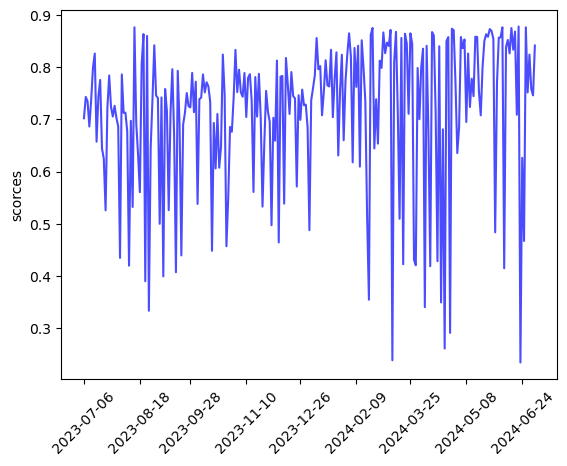

In [10]:
#NN on real data

True_open_yestaday = torch.tensor(NVDA_True_Open[:-1]).view(-1, 1).float()
True_close_yestaday = torch.tensor(NVDA_True_Close[:-1]).view(-1, 1).float()
True_open_today = torch.tensor(NVDA_True_Open[1:]).view(-1, 1).float()
True_data = torch.cat((True_open_yestaday, True_close_yestaday, True_open_today), dim=1)
True_scorces = NN_training.Generate_scorce(my_model,True_data).view(-1).detach().numpy()

print("The first data point is", Time_step_True[0])
print("Analysis start at", Time_step_True[1] ,'to', Time_step_True[-1])
plt.plot(Time_step_True[1:],True_scorces,alpha=0.7,color="blue")
plt.ylabel("scorces")
ax2 = plt.gca()
ax2.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

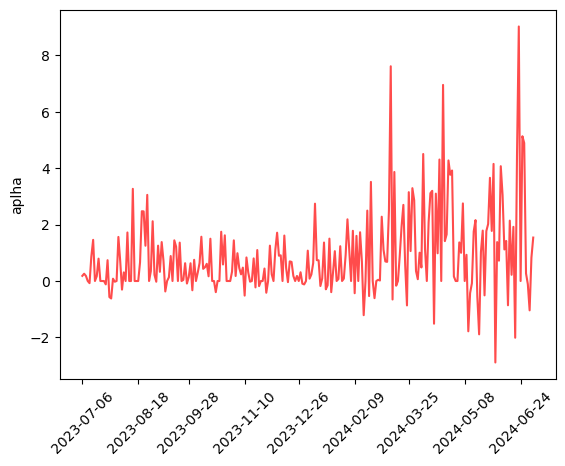

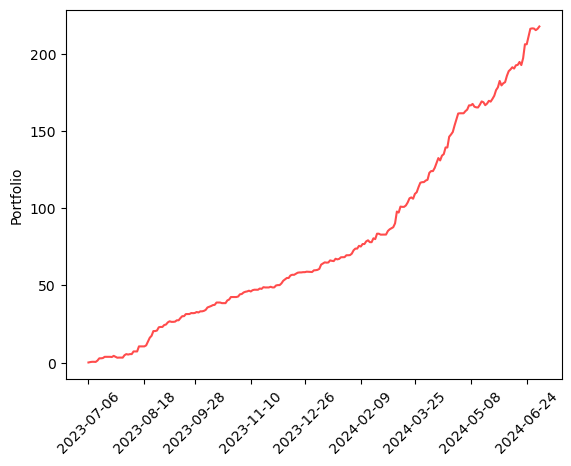

If we apply this strategy IRL, on 2024-07-03 the portfolio would be:  217.60700800000012
Number of Call =  175
Number of Short =  28
Number of trading day =  251


In [11]:
#Trading on real data
# if the scorce > 0.7, I buy;
#else if scorce < 0.5, I short;
#else, in between, I hold
True_alpha = []
Call = 0
Short = 0
No_action = 0
for jj in range(len(True_scorces)):
    if True_scorces[jj] > 0.7:
        action = 1
        Call += 1
    elif True_scorces[jj] < 0.5:
        action = -1
        Short +=1
    else:
        action = 0
        No_action += 1
    gain = (NVDA_True_Close[jj] - NVDA_True_Open[jj])*action
    True_alpha.append(gain)
True_alpha = np.array(True_alpha)
True_Portfolio = np.cumsum(True_alpha)

plt.plot(Time_step_True[1:],True_alpha,alpha=0.7,color="red")
plt.ylabel("aplha")
ax3 = plt.gca()
ax3.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

plt.plot(Time_step_True[1:],True_Portfolio,alpha=0.7,color="red")
plt.ylabel("Portfolio")
ax3 = plt.gca()
ax3.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

print("If we apply this strategy IRL, on",Time_step_True[-1], "the portfolio would be: ", True_Portfolio[-1])
print("Number of Call = ", Call)
print("Number of Short = ", Short)
print("Number of trading day = ", Call + Short + No_action)

Testing on data from  2024-06-03 to 2024-07-03
Optimizing parameters using data from  2024-02-23 to 2024-06-03
-------------------------------------------------------------------------
Optimization finished
Using the optimal call and short scorce: 0.76 0.76
-------------------------------------------------------------------------
Using NN strategy
Net worth(Open) on  2024-07-03 :
16.0 share of stock at  128.279999
87.94278299999951 USD in cash
Net worth(Open) =  2034.5028469999995 USD
Delta =  34.50284699999952 USD
Groth =  1.7251423499999758 %
Number of Call = 14
Number of Short = 8
Number of no action = 0
-------------------------------------------------------------------------
Control: buy and hold
Net worth(Open) on  2024-07-03 :
Net worth(Open) =  2136.663034 USD
Delta =  136.66303400000015 USD
Groth =  6.833151700000008 %
-------------------------------------------------------------------------


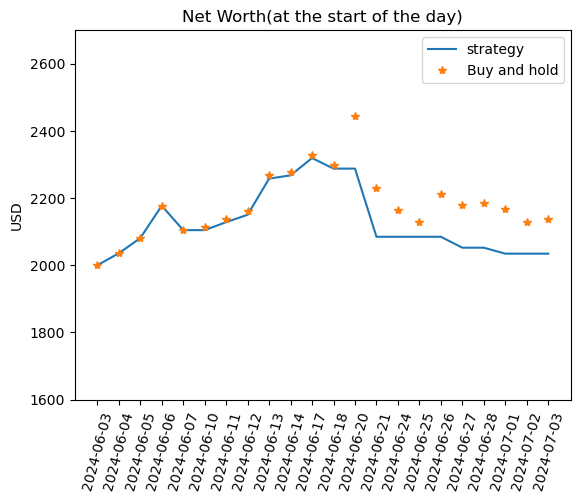

In [12]:
## Real life trading

Principle = 2000 #in USD

True_price_End_date = datetime.date(2024,7,3)
True_price_start_date = True_price_End_date - datetime.timedelta(days=30)
 
print("Testing on data from ", True_price_start_date, "to", True_price_End_date)
Time_step_True_restricted, NVDA_True_Open_restricted = MC_Sim.Slice_time_series(NVDA_True_Open,Time_step_True,True_price_start_date,True_price_End_date)

########################################################################################################################

#Optimizing the parameter using past 30 days data
Opt_End_date = True_price_start_date
Opt_start_date=True_price_start_date - datetime.timedelta(days=101)

print("Optimizing parameters using data from ", Opt_start_date, "to", Opt_End_date)
print("-------------------------------------------------------------------------")


Time_step_Opt, Opt_Open_restricted = MC_Sim.Slice_time_series(NVDA_True_Open,Time_step_True,Opt_start_date,Opt_End_date)
Time_step_Opt, Opt_scorce_restricted = MC_Sim.Slice_time_series(True_scorces,Time_step_True,Opt_start_date,Opt_End_date)

Call_scorce_opt, Short_scorce_opt = Trading.optimize_parameters(Principle, Opt_Open_restricted, Opt_scorce_restricted)

print("Optimization finished")
print("Using the optimal call and short scorce:", Call_scorce_opt, Short_scorce_opt)
print("-------------------------------------------------------------------------")

###################################################################################################################################################

T_score, NVDA_True_scorce_restricted = MC_Sim.Slice_time_series(True_scorces,Time_step_True[1:],True_price_start_date,True_price_End_date) #Scorce start from Open[1] data point
_, NVDA_True_Close_restricted = MC_Sim.Slice_time_series(NVDA_True_Close,Time_step_True,True_price_start_date,True_price_End_date)

True_share, cash, True_share_worth_record, True_cash_worth_record, N_C, N_S, N_N = Trading.Trade(Principle,NVDA_True_Open_restricted, NVDA_True_scorce_restricted, Call_scorce_opt, Short_scorce_opt)
True_Total_worth = True_share_worth_record + True_cash_worth_record
print("Using NN strategy")
print("Net worth(Open) on ", True_price_End_date, ":")
print(True_share, "share of stock at ", NVDA_True_Close[-1])
print(cash, "USD in cash")
print("Net worth(Open) = ", True_share_worth_record[-1] + cash, "USD")
print("Delta = ", True_share_worth_record[-1] + cash - Principle, "USD")
print("Groth = ", (True_share_worth_record[-1] + cash - Principle)/Principle*100, "%")

print("Number of Call =", N_C)
print("Number of Short =", N_S)
print("Number of no action =", N_N)
print("-------------------------------------------------------------------------")

Control_share, Control_stock_worth_record, Control_cash_record = Trading.Buy_and_hold(Principle,NVDA_True_Open_restricted)
Control_Total_worth = Control_stock_worth_record + Control_cash_record

print("Control: buy and hold")
print("Net worth(Open) on ", True_price_End_date, ":")
print("Net worth(Open) = ", Control_stock_worth_record[-1] + Control_cash_record[-1], "USD")
print("Delta = ", Control_stock_worth_record[-1] + Control_cash_record[-1] - Principle, "USD")
print("Groth = ", (Control_stock_worth_record[-1] + Control_cash_record[-1] - Principle)/Principle*100, "%")
print("-------------------------------------------------------------------------")
#plt.plot(Time_step_True_restricted[1:-1], True_share_worth_record, label="Share worth")
#plt.plot(Time_step_True_restricted[1:-1], True_cash_worth_record, label="cash worth")
plt.plot(Time_step_True_restricted, True_Total_worth, label="strategy")

plt.plot(Time_step_True_restricted,Control_Total_worth, "*", label="Buy and hold")
plt.ylabel("USD")
plt.ylim(1600,2700)
plt.title("Net Worth(at the start of the day)")
plt.legend()
ax4 = plt.gca()
#ax4.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=75)
plt.show()